In [1]:
%matplotlib inline
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from refnx.reflect import SLD, Structure, ReflectModel, use_reflect_backend, Spline, Slab
from refnx.analysis import Parameter, Objective, CurveFitter, PDF
from refnx.dataset import ReflectDataset
from tof_simulator import ReflectSimulator
from maxent_general import MaxEnt
from scipy.stats import beta
from scipy.integrate import quad

from functools import partial
from copy import deepcopy
from multiprocessing import Pool, set_start_method

In [2]:
# set_start_method('fork')

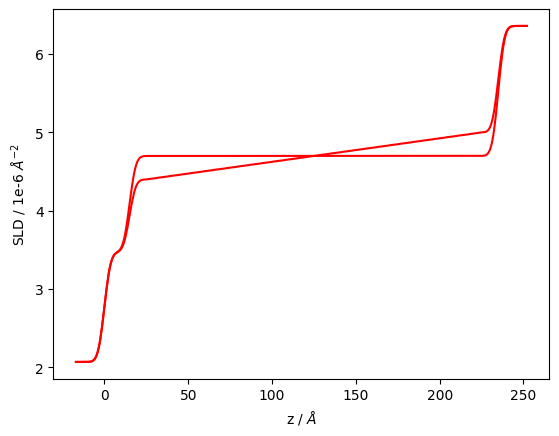

In [3]:
air = SLD(0.0)
si = SLD(2.07)
sio2 = SLD(3.47)
d2o = SLD(6.36)
sld_1_5 = SLD(4.4)
sld_2_0 = SLD(4.7)
sld_2_5 = SLD(5.0)
spl = Spline(200, [], [], zgrad=False)


s = si | sio2(15, 3) | sld_1_5(10, 3) | spl | sld_2_5(10, 3) |  d2o(0, 3)
s_mod = si | sio2(15, 3) | sld_2_0(220, 3) | d2o(0, 3)
model = ReflectModel(s, bkg=1e-6)
model_mod = ReflectModel(s_mod, bkg=1e-6)

fig, ax = s.plot();
s_mod.plot(fig=fig);

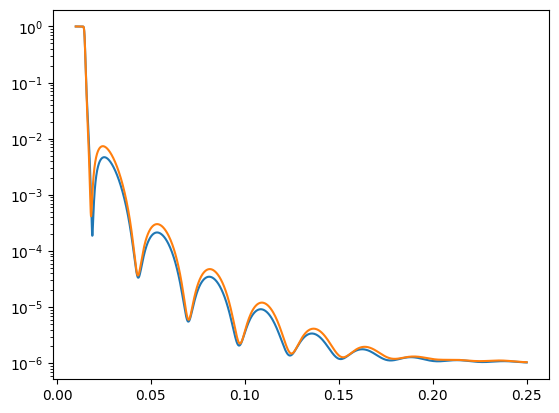

In [4]:
q = np.geomspace(0.01, 0.25, 1001)
plt.plot(q, model(q))
plt.plot(q, model_mod(q));
plt.yscale('log')

In [5]:
simulator0 = ReflectSimulator(model, 0.8, direct_spectrum='PLP0000711.nx.hdf', rebin=2)
simulator1 = ReflectSimulator(model, 3.5, direct_spectrum='PLP0000711.nx.hdf', rebin=2)

In [6]:
simulator0.sample_direct(3000000)
simulator1.sample_direct(3000000)

simulator0.sample(2400000)
for i in tqdm(range(400)):
    # 150e6 beam monitor counts
    simulator1.sample(1000000)

data = ReflectDataset()
data += simulator0.reflectivity
data += simulator1.reflectivity

data.save('slow_gradient.dat')

100%|█████████████████████████████████████████| 400/400 [05:20<00:00,  1.25it/s]


In [7]:
data = ReflectDataset('slow_gradient.dat')

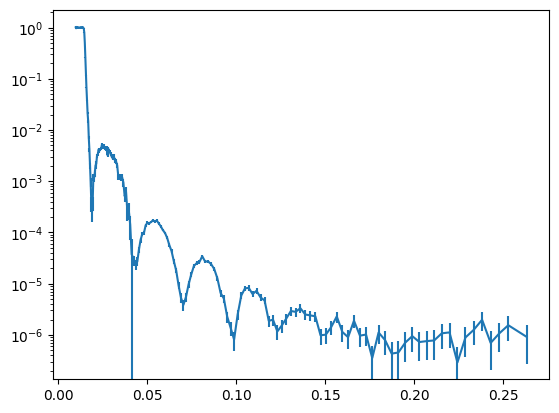

In [8]:
data.plot()
plt.yscale('log')

-786.7462037341412: : 21it [00:00, 48.43it/s]


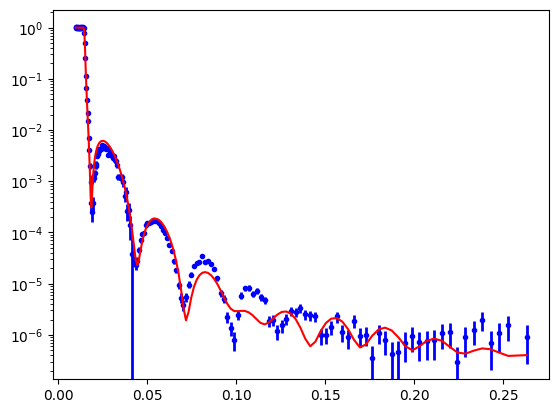

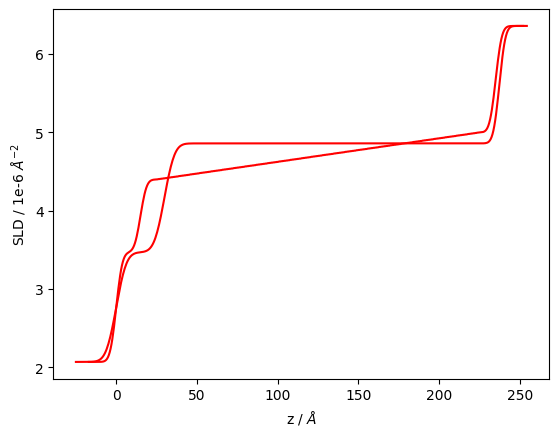

In [9]:
lsld = SLD(3.0)
t = Parameter(200)
r = Parameter(5)
l = Slab(t, lsld, r)
sio2_l = sio2(15, 5)

sfit = si | sio2_l | l | d2o(0, 3)

mfit = ReflectModel(sfit)

sio2_l.thick.setp(vary=True, bounds=(5, 30))
t.setp(vary=True, bounds=(100, 300))
lsld.real.setp(vary=True, bounds=(3, 6))
mfit.bkg.setp(vary=True, bounds=(0, 2e-6))

obj = Objective(mfit, data)
fitter = CurveFitter(obj)

fitter.fit('differential_evolution')
obj.plot()
plt.yscale('log')
fig, ax = sfit.plot()
s.plot(fig=fig);

In [10]:
print(obj)

________________________________________________________________________________
Objective - 11028960912
Dataset = slow_gradient
datapoints = 164
chi2 = 1628.288810878823
Weighted = True
Transform = None
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=1  (fixed) , bounds=[-inf, inf]>
<Parameter:     'bkg'     , value=3.36924e-07 +/- 6.59e-08, bounds=[0.0, 2e-06]>
<Parameter:'dq - resolution', value=5  (fixed) , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0  (fixed) , bounds=[-inf, inf]>
_

-1070.7635390401024: : 294it [00:45,  6.42it/s]
/Users/andrew/Documents/Andy/programming/refnx/refnx/analysis/objective.py:770: LinAlgWarning: The following Parameters have no effect on Objective.residuals, please consider fixing them.
[Parameter(value=0.002989671829600078, name='alpha', vary=True, bounds=PDF(<scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2b78d2c80>), constraint=None)]
  warnings.warn(


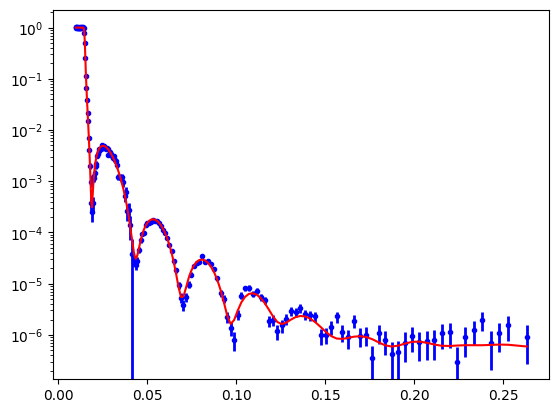

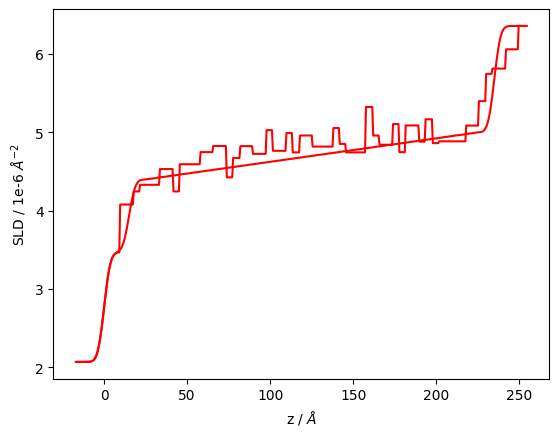

In [46]:
sio2_l_max = sio2(15, 3)
sld1 = SLD(4.4)
t1 = Parameter(10)
r1 = Parameter(3)
l1 = Slab(t1, sld1, r1)

dist = beta(0.1, 700)
alpha = Parameter(0.00468, "alpha", vary=True)
alpha.bounds = PDF(dist)

maxent = MaxEnt(60, 4, 3.5, 6.36, lsld.real.value, alpha=alpha, sigma=None)

s_max = si | sio2_l_max | maxent | d2o(0, 0)
# s_max = si | sio2_l_max | l1 | maxent | d2o(0, 0)
model_max = ReflectModel(s_max, bkg=1e-6)
model.threads = 1
s_max.contract = 1.5

maxent.slab_thickness.setp(vary=False, bounds=(3, 10))
sio2_l_max.thick.setp(vary=True, bounds=(5, 20))
sld1.real.setp(vary=True, bounds=(4.2, 6.36))
model_max.bkg.setp(vary=True, bounds=(0, 2e-6))


obj_max = Objective(model_max, data)
fitter_max = CurveFitter(obj_max)

fitter_max.fit('differential_evolution', target="nlpost", popsize=2)
obj_max.plot()
plt.yscale('log')
fig, ax = s.plot()
s_max.plot(fig=fig);


In [43]:
obj_max.chisqr()

488.07974494135436

In [44]:
print(obj_max)

________________________________________________________________________________
Objective - 11666389264
Dataset = slow_gradient
datapoints = 164
chi2 = 488.07974494135436
Weighted = True
Transform = None
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=1  (fixed) , bounds=[-inf, inf]>
<Parameter:     'bkg'     , value=0 +/- 0.00303, bounds=[0.0, 2e-06]>
<Parameter:'dq - resolution', value=5  (fixed) , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0  (fixed) , bounds=[-inf, inf]>
___________

In [ ]:
def fitit(objective, a):
    obj = deepcopy(objective)
    alpha = obj.model.structure[-2].alpha
    alpha.setp(value=a, vary=False)
    
    fitter = CurveFitter(obj)
    fitter.fit('differential_evolution', target="nlpost", popsize=2, verbose=False)
    print(a)
    return obj.chisqr(), obj.logl(), np.array(obj.varying_parameters())

a = np.geomspace(1e-4, 0.5, 41)
f = partial(fitit, obj_max)

with Pool() as p:
    output = p.map(f, a)

In [ ]:
obj_max.varying_parameters()

In [ ]:
chi2 = np.zeros_like(a)
logl = np.zeros_like(a)

for i, v in enumerate(s):
    chi2[i] = v[0]
    logl[i] = v[1]

In [ ]:
plt.scatter(np.log(a), np.log(chi2))
# plt.xscale('log')

In [ ]:
_v

In [ ]:
_v = np.searchsorted(np.log(a), -5)
r0 = a[_v:]
c0 = chi2[_v:]

In [ ]:
plt.plot(np.log(r0), np.log(c0))

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
cf0 = curve_fit(lambda x, a, b: a + b * x, np.log(r0), np.log(c0))
print(cf0)

In [ ]:
_v = np.searchsorted(np.log(a), [-9, -6.5])
r1 = a[_v[0]:_v[1]]
c1 = chi2[_v[0]:_v[1]]

In [ ]:
cf1 = curve_fit(lambda x, a, b: a + b * x, np.log(r1), np.log(c1))

In [ ]:
p0 = np.polynomial.Polynomial(cf0[0])
p1 = np.polynomial.Polynomial(cf1[0])

In [ ]:
p0

In [ ]:
p1

In [ ]:
intersect = p1 - p0

In [ ]:
np.exp(intersect.coef[0] / -intersect.coef[1])

In [ ]:
def fit_piecewise(logx, logy, p2_deg=0):
    """ piecewise linear fit (e.g. for chi2)

    The curve is fitted by two linear curves; for the first few indices,
    the fit is done by choosing both the slope and the y-axis intercept.
    If ``p2_deg`` is ``0``, a constant curve is fitted (i.e., the only
    fit parameter is the y-axis intercept) for the last few indices,
    if it is ``1`` also the slope is fitted.

    The point (i.e., data point index) up to where the first linear curve
    is used (and from where the second linear curve is used) is also determined
    by minimizing the misfit. I.e., we search the minimum misfit with
    respect to the fit parameters of the linear curve and with respect
    to the index up to where the first curve is used.

    Parameters
    ----------
    logx : array
        the x-coordinates of the curve that should be fitted piecewise
    logy : array
        the y-corrdinates of the curve that should be fitted piecewise
    p2_deg : int
        ``0`` or ``1``, giving the polynomial degree of the second curve
    """
    chi2 = np.full(len(logx), np.nan)
    p1 = [0] * len(logx)
    p2 = [0] * len(logx)

    def denan(what, check=None):
        if check is None:
            check = what
        return what[np.logical_not(np.isnan(check))]
    for i in range(2, len(logx) - 2):
        chi2[i] = 0.0
        try:
            p1[i], residuals, rank, singular_values, rcond = np.polyfit(
                denan(logx[:i], logy[:i]), denan(logy[:i]), deg=1, full=True)
            if len(residuals) > 0:
                chi2[i] += residuals[0]
            p2[i], residuals, rank, singular_values, rcond = np.polyfit(
                denan(logx[i:], logy[i:]), denan(logy[i:]),
                deg=p2_deg, full=True)
            if len(residuals) > 0:
                chi2[i] += residuals[0]
        except TypeError:
            p1[i] = np.nan
            p2[i] = np.nan
            chi2[i] = np.nan
    i = np.nanargmin(chi2)
    if np.isnan(i):
        raise ValueError('chi2 is all NaN')

    X_x = ((p2[i][1] if p2_deg == 1 else p2[i][0]) - p1[i][1]) / \
        (p1[i][0] - (p2[i][0] if p2_deg == 1 else 0.0))
    idx = np.nanargmin(np.abs(logx - X_x))

    if np.isnan(idx):
        raise ValueError('abs(logx - X_x) is all NaN')

    return idx, (p1[i], p2[i])

In [ ]:
fit_piecewise(np.log(1/a), np.log(chi2), p2_deg=1)

In [ ]:
1/np.exp(5.30)